# Test Door Key Offline Training with d3rlpy and Decision Transformer

We will make new experiments in Door Key 16x16 environment from Minigrid Gym with DT from d3rlpy.

In [1]:
# Test if we are running on CoLab or not
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  !apt-get install -y xvfb ffmpeg > /dev/null 2>&1
  %pip install pyvirtualdisplay pygame moviepy > /dev/null 2>&1
  %pip install d3rlpy
  %pip install matplotlib
else:
  print('Not running on CoLab')

Not running on CoLab


In [2]:
# Directory creation
import os
path = "./models"
path = "./datasets"
path = "./videos/video-doorkey-dt-d3rlpy"

In [3]:
import gymnasium as gym
from gymnasium import spaces
from minigrid.envs import DoorKeyEnv
from gymnasium.core import ActType, ObsType
from typing import Any, SupportsFloat
import random, math
import numpy as np

from gymnasium.envs.registration import register

register(
    id="MiniGrid-DoorKey-16x16-v0",
    entry_point="minigrid.envs:DoorKeyEnv",
    kwargs={"size": 16},
)
    

pygame 2.5.2 (SDL 2.28.2, Python 3.10.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment MiniGrid-DoorKey-16x16-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


We created a PartialObsWrapper to augment flattened partial observations with the agent's direction in a single vector. This is beneficial for training the Decision Transformer algorithm.

Additionally, we developed a PartialAndFullyObsWrapper to enhance flattened partial observations with the agent's direction in just one vector, and to append the full observation to the partial observation. This is advantageous for sampling data from the environment using the trained DQN agent, and for saving the data in a dataset.

In [4]:
import minigrid
from minigrid.core.constants import COLOR_TO_IDX, OBJECT_TO_IDX
from gymnasium.core import ObservationWrapper

class PartialObsWrapper(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

        new_image_space = spaces.Box(
            low=0,
            high=255,
            shape=(((self.env.agent_view_size * self.env.agent_view_size *  3) + 1),),  
            dtype="uint8",
        )

        self.observation_space = spaces.Dict(
            {**self.observation_space.spaces, "image": new_image_space}
        )

    def observation(self, obs):
        image = np.concatenate((obs["image"].flatten(), np.array([obs["direction"]])))

        return {"image": image}

class PartialAndFullyObsWrapper(ObservationWrapper):

    def __init__(self, env):
        super().__init__(env)

        new_image_space = spaces.Box(
            low=0,
            high=255,
            shape=(self.env.width, self.env.height, 3),  # number of cells
            dtype="uint8",
        )

        self.observation_space = spaces.Dict(
            {**self.observation_space.spaces, "image": new_image_space}
        )

    def observation(self, obs):
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array(
            [OBJECT_TO_IDX["agent"], COLOR_TO_IDX["red"], env.agent_dir]
        )

        partial_image = np.concatenate((obs["image"].flatten(), np.array([obs["direction"]])))

        return {"partial_image": partial_image, "image": full_grid}

def create_env(env_key, max_episode_steps=100, isPartialObs=False, isFullyObs=True, is_video=False):
    
    render_mode = None

    if is_video == True:
        render_mode = 'rgb_array'

    env = gym.make(env_key, max_episode_steps=max_episode_steps, render_mode=render_mode, see_through_walls=True)

    if isPartialObs and isFullyObs:
        env =  PartialAndFullyObsWrapper(env)
    elif isPartialObs:
        env = PartialObsWrapper(env)
        env = minigrid.wrappers.ImgObsWrapper(env)
    elif isFullyObs:
        env = minigrid.wrappers.FullyObsWrapper(env)
        env = minigrid.wrappers.ImgObsWrapper(env)

    return env


In [5]:
import d3rlpy

config = {
    "seed": 1,
    "dataset_size": 10000,
    "epsilon": 0.3,
    "max_episode_steps": 200,
    "experiment_name": "door-key-16x16",
    "device": "cuda:0"
}

env_key = "MiniGrid-DoorKey-16x16-v0"

env = create_env(env_key, max_episode_steps=config["max_episode_steps"])



/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(


We develop a CustomReplayBuffer to exclude episodes that have zero or negative rewards. Our goal is to retain only those episodes in which the agent is making progress towards the goal.

In [6]:
import numpy as np
from tqdm import tqdm


class CustomReplayBuffer(d3rlpy.dataset.ReplayBuffer):
    ' Custom Replay Buffer to clip episodes with negative rewards'
    
    def clip_episode(self, terminated: bool) -> None:
        r"""Clips the current episode.

        Args:
            terminated: Flag to represent environment termination.
        """

        episode_to_remove = None
        # Check if the episode's reward is 0 or negative
        if not terminated and self._writer._active_episode.rewards.mean() <= 0:
            episode_to_remove = self._writer._active_episode
            
        self._writer.clip_episode(terminated)

        if episode_to_remove is not None:
            # Remove all transitions associated with the episode to remove
            self._buffer._transitions = [(ep, idx) for ep, idx in self._buffer._transitions if ep is not episode_to_remove]
            self._buffer.episodes.remove(episode_to_remove)  



We train the Discrete Decision Transformer agent using the data sampled from the environment. We employ the PartialObsWrapper to augment the partial observation with the agent's direction.

In [7]:
env = create_env(env_key, max_episode_steps=config["max_episode_steps"], isPartialObs=True, isFullyObs=False)
env_eval = create_env(env_key, max_episode_steps=config["max_episode_steps"], isPartialObs=True, isFullyObs=False)

buffer = d3rlpy.dataset.InfiniteBuffer()
dataset = CustomReplayBuffer(buffer, env=env, cache_size=config["max_episode_steps"])

dataset.load('./datasets/dataset_door-key-dqn-16x16-mixed.d3', buffer=buffer)

experiment_name = config["experiment_name"]
experiment_seed = config["seed"]

2024-01-23 16:35.54 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('uint8')], shape=[(148,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2024-01-23 16:35.54 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-01-23 16:35.54 [info     ] Action size has been automatically determined. action_size=7


/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_view_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_view_size` for environment variables or `env.get_wrapper_attr('agent_view_size')` that will search the reminding wrappers.
  logger.warn(


2024-01-23 16:36.01 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('uint8')], shape=[(148,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2024-01-23 16:36.01 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-01-23 16:36.01 [info     ] Action size has been automatically determined. action_size=7


In [8]:
dt = d3rlpy.algos.DiscreteDecisionTransformerConfig(
    batch_size=64,
    encoder_factory=d3rlpy.models.VectorEncoderFactory(
    ),
    optim_factory=d3rlpy.models.GPTAdamWFactory(),
    position_encoding_type=d3rlpy.PositionEncodingType.GLOBAL,
    context_size=60,
    num_heads=8,
    num_layers=3,
    max_timestep=200,
).create(device=config["device"])

dt.fit(
    dataset,
    n_steps=5000,
    n_steps_per_epoch=1000,
    experiment_name=f"DT_{experiment_name}_{experiment_seed}"
)

2024-01-23 16:36.02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('uint8')], shape=[(148,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[()]), reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]]), action_space=<ActionSpace.DISCRETE: 2>, action_size=7)
2024-01-23 16:36.02 [info     ] Directory is created at d3rlpy_logs/DT_door-key-16x16_1_20240123163602
2024-01-23 16:36.02 [debug    ] Building models...            
2024-01-23 16:36.02 [debug    ] Models have been built.       
2024-01-23 16:36.02 [info     ] Parameters                     params={'observation_shape': [148], 'action_size': 7, 'config': {'type': 'discrete_decision_transformer', 'params': {'batch_size': 64, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'context_size': 60, 'max_timestep': 200, 'learning_rate': 0

Epoch 1/5:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:37.16 [info     ] DT_door-key-16x16_1_20240123163602: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.007063937664031982, 'time_algorithm_update': 0.06617516088485718, 'loss': 0.7351842252016068, 'learning_rate': 0.0005957920098014106, 'time_step': 0.07336047625541688} step=1000
2024-01-23 16:37.16 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240123163602/model_1000.d3


Epoch 2/5:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:38.28 [info     ] DT_door-key-16x16_1_20240123163602: epoch=2 step=2000 epoch=2 metrics={'time_sample_batch': 0.0070643494129180905, 'time_algorithm_update': 0.06369453978538513, 'loss': 0.669780635714531, 'learning_rate': 0.0005776998422955017, 'time_step': 0.0708733184337616} step=2000
2024-01-23 16:38.28 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240123163602/model_2000.d3


Epoch 3/5:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:39.40 [info     ] DT_door-key-16x16_1_20240123163602: epoch=3 step=3000 epoch=3 metrics={'time_sample_batch': 0.006927919626235962, 'time_algorithm_update': 0.06443776559829711, 'loss': 0.6558718840777874, 'learning_rate': 0.0005407962393305974, 'time_step': 0.0714756350517273} step=3000
2024-01-23 16:39.40 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240123163602/model_3000.d3


Epoch 4/5:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:40.54 [info     ] DT_door-key-16x16_1_20240123163602: epoch=4 step=4000 epoch=4 metrics={'time_sample_batch': 0.00718519139289856, 'time_algorithm_update': 0.06657832288742066, 'loss': 0.6500256375968456, 'learning_rate': 0.0004884243797659794, 'time_step': 0.07387579298019409} step=4000
2024-01-23 16:40.54 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240123163602/model_4000.d3


Epoch 5/5:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:42.08 [info     ] DT_door-key-16x16_1_20240123163602: epoch=5 step=5000 epoch=5 metrics={'time_sample_batch': 0.00718578314781189, 'time_algorithm_update': 0.06618794417381287, 'loss': 0.6380596511662007, 'learning_rate': 0.0004236893947438458, 'time_step': 0.07349515414237975} step=5000
2024-01-23 16:42.08 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240123163602/model_5000.d3


In [9]:
bc = d3rlpy.algos.DiscreteBCConfig().create(device="cuda:0")

bc.fit(
   dataset,
   n_steps=10000,
   n_steps_per_epoch=1000,
   experiment_name=f"BC_{experiment_name}_{experiment_seed}"
)



2024-01-23 16:42.08 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('uint8')], shape=[(148,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[()]), reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]]), action_space=<ActionSpace.DISCRETE: 2>, action_size=7)
2024-01-23 16:42.08 [info     ] Directory is created at d3rlpy_logs/BC_door-key-16x16_1_20240123164208
2024-01-23 16:42.08 [debug    ] Building models...            
2024-01-23 16:42.08 [debug    ] Models have been built.       
2024-01-23 16:42.09 [info     ] Parameters                     params={'observation_shape': [148], 'action_size': 7, 'config': {'type': 'discrete_bc', 'params': {'batch_size': 100, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 0.001, 'optim_factory': {'type': 'adam', 'params': {'betas'

Epoch 1/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:42.17 [info     ] BC_door-key-16x16_1_20240123164208: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.005256834030151367, 'time_algorithm_update': 0.003358738899230957, 'loss': 3.666518340587616, 'time_step': 0.008672630310058594} step=1000
2024-01-23 16:42.17 [info     ] Model parameters are saved to d3rlpy_logs/BC_door-key-16x16_1_20240123164208/model_1000.d3


Epoch 2/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:42.26 [info     ] BC_door-key-16x16_1_20240123164208: epoch=2 step=2000 epoch=2 metrics={'time_sample_batch': 0.005364888191223145, 'time_algorithm_update': 0.0033666319847106933, 'loss': 3.6417443063259123, 'time_step': 0.008789623260498047} step=2000
2024-01-23 16:42.26 [info     ] Model parameters are saved to d3rlpy_logs/BC_door-key-16x16_1_20240123164208/model_2000.d3


Epoch 3/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:42.35 [info     ] BC_door-key-16x16_1_20240123164208: epoch=3 step=3000 epoch=3 metrics={'time_sample_batch': 0.005203718662261963, 'time_algorithm_update': 0.0032201049327850342, 'loss': 3.632483716249466, 'time_step': 0.008479498624801636} step=3000
2024-01-23 16:42.35 [info     ] Model parameters are saved to d3rlpy_logs/BC_door-key-16x16_1_20240123164208/model_3000.d3


Epoch 4/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:42.43 [info     ] BC_door-key-16x16_1_20240123164208: epoch=4 step=4000 epoch=4 metrics={'time_sample_batch': 0.005258885860443116, 'time_algorithm_update': 0.003258589029312134, 'loss': 3.6286313433647157, 'time_step': 0.008575014591217041} step=4000
2024-01-23 16:42.43 [info     ] Model parameters are saved to d3rlpy_logs/BC_door-key-16x16_1_20240123164208/model_4000.d3


Epoch 5/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:42.52 [info     ] BC_door-key-16x16_1_20240123164208: epoch=5 step=5000 epoch=5 metrics={'time_sample_batch': 0.005265893459320069, 'time_algorithm_update': 0.003336984872817993, 'loss': 3.62415193939209, 'time_step': 0.0086631338596344} step=5000
2024-01-23 16:42.52 [info     ] Model parameters are saved to d3rlpy_logs/BC_door-key-16x16_1_20240123164208/model_5000.d3


Epoch 6/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:43.01 [info     ] BC_door-key-16x16_1_20240123164208: epoch=6 step=6000 epoch=6 metrics={'time_sample_batch': 0.005269104957580566, 'time_algorithm_update': 0.0034061176776885986, 'loss': 3.6209991335868836, 'time_step': 0.008732513666152955} step=6000
2024-01-23 16:43.01 [info     ] Model parameters are saved to d3rlpy_logs/BC_door-key-16x16_1_20240123164208/model_6000.d3


Epoch 7/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:43.09 [info     ] BC_door-key-16x16_1_20240123164208: epoch=7 step=7000 epoch=7 metrics={'time_sample_batch': 0.005079066038131714, 'time_algorithm_update': 0.003237732410430908, 'loss': 3.6184703981876374, 'time_step': 0.008370547771453858} step=7000
2024-01-23 16:43.09 [info     ] Model parameters are saved to d3rlpy_logs/BC_door-key-16x16_1_20240123164208/model_7000.d3


Epoch 8/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:43.18 [info     ] BC_door-key-16x16_1_20240123164208: epoch=8 step=8000 epoch=8 metrics={'time_sample_batch': 0.005137563467025757, 'time_algorithm_update': 0.0032252540588378906, 'loss': 3.615667845487595, 'time_step': 0.008417862653732299} step=8000
2024-01-23 16:43.18 [info     ] Model parameters are saved to d3rlpy_logs/BC_door-key-16x16_1_20240123164208/model_8000.d3


Epoch 9/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:43.27 [info     ] BC_door-key-16x16_1_20240123164208: epoch=9 step=9000 epoch=9 metrics={'time_sample_batch': 0.005377385139465332, 'time_algorithm_update': 0.003316025733947754, 'loss': 3.615421350479126, 'time_step': 0.008752762079238892} step=9000
2024-01-23 16:43.27 [info     ] Model parameters are saved to d3rlpy_logs/BC_door-key-16x16_1_20240123164208/model_9000.d3


Epoch 10/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:43.35 [info     ] BC_door-key-16x16_1_20240123164208: epoch=10 step=10000 epoch=10 metrics={'time_sample_batch': 0.005222683906555176, 'time_algorithm_update': 0.0031594436168670653, 'loss': 3.6129138650894164, 'time_step': 0.008439539670944214} step=10000
2024-01-23 16:43.35 [info     ] Model parameters are saved to d3rlpy_logs/BC_door-key-16x16_1_20240123164208/model_10000.d3


[(1,
  {'time_sample_batch': 0.005256834030151367,
   'time_algorithm_update': 0.003358738899230957,
   'loss': 3.666518340587616,
   'time_step': 0.008672630310058594}),
 (2,
  {'time_sample_batch': 0.005364888191223145,
   'time_algorithm_update': 0.0033666319847106933,
   'loss': 3.6417443063259123,
   'time_step': 0.008789623260498047}),
 (3,
  {'time_sample_batch': 0.005203718662261963,
   'time_algorithm_update': 0.0032201049327850342,
   'loss': 3.632483716249466,
   'time_step': 0.008479498624801636}),
 (4,
  {'time_sample_batch': 0.005258885860443116,
   'time_algorithm_update': 0.003258589029312134,
   'loss': 3.6286313433647157,
   'time_step': 0.008575014591217041}),
 (5,
  {'time_sample_batch': 0.005265893459320069,
   'time_algorithm_update': 0.003336984872817993,
   'loss': 3.62415193939209,
   'time_step': 0.0086631338596344}),
 (6,
  {'time_sample_batch': 0.005269104957580566,
   'time_algorithm_update': 0.0034061176776885986,
   'loss': 3.6209991335868836,
   'time_st

In [10]:
cql = d3rlpy.algos.DiscreteCQLConfig().create(device="cuda:0")

cql.fit(
   dataset,
   n_steps=10000,
   n_steps_per_epoch=1000,
   experiment_name=f"CQL_{experiment_name}_{experiment_seed}"
)

2024-01-23 16:43.35 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('uint8')], shape=[(148,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[()]), reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]]), action_space=<ActionSpace.DISCRETE: 2>, action_size=7)
2024-01-23 16:43.35 [info     ] Directory is created at d3rlpy_logs/CQL_door-key-16x16_1_20240123164335
2024-01-23 16:43.35 [debug    ] Building models...            
2024-01-23 16:43.35 [debug    ] Models have been built.       
2024-01-23 16:43.35 [info     ] Parameters                     params={'observation_shape': [148], 'action_size': 7, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'be

Epoch 1/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:43.44 [info     ] CQL_door-key-16x16_1_20240123164335: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.002135777235031128, 'time_algorithm_update': 0.005964293241500855, 'loss': 1.7255823192596436, 'td_loss': 0.09808130854554474, 'conservative_loss': 1.6275010098218918, 'time_step': 0.008197107553482056} step=1000
2024-01-23 16:43.44 [info     ] Model parameters are saved to d3rlpy_logs/CQL_door-key-16x16_1_20240123164335/model_1000.d3


Epoch 2/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:43.52 [info     ] CQL_door-key-16x16_1_20240123164335: epoch=2 step=2000 epoch=2 metrics={'time_sample_batch': 0.0021697359085083006, 'time_algorithm_update': 0.005891984224319458, 'loss': 1.6754161316156386, 'td_loss': 0.11744065929204225, 'conservative_loss': 1.5579754718542098, 'time_step': 0.008151657581329345} step=2000
2024-01-23 16:43.52 [info     ] Model parameters are saved to d3rlpy_logs/CQL_door-key-16x16_1_20240123164335/model_2000.d3


Epoch 3/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:44.00 [info     ] CQL_door-key-16x16_1_20240123164335: epoch=3 step=3000 epoch=3 metrics={'time_sample_batch': 0.00205194091796875, 'time_algorithm_update': 0.005593382120132447, 'loss': 1.651921894788742, 'td_loss': 0.12957075955346226, 'conservative_loss': 1.5223511360883712, 'time_step': 0.0077358694076538085} step=3000
2024-01-23 16:44.00 [info     ] Model parameters are saved to d3rlpy_logs/CQL_door-key-16x16_1_20240123164335/model_3000.d3


Epoch 4/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:44.07 [info     ] CQL_door-key-16x16_1_20240123164335: epoch=4 step=4000 epoch=4 metrics={'time_sample_batch': 0.0019906671047210693, 'time_algorithm_update': 0.005496113061904907, 'loss': 1.6383602160215378, 'td_loss': 0.13689786883443594, 'conservative_loss': 1.5014623447656632, 'time_step': 0.007564504623413086} step=4000
2024-01-23 16:44.07 [info     ] Model parameters are saved to d3rlpy_logs/CQL_door-key-16x16_1_20240123164335/model_4000.d3


Epoch 5/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:44.16 [info     ] CQL_door-key-16x16_1_20240123164335: epoch=5 step=5000 epoch=5 metrics={'time_sample_batch': 0.002069416046142578, 'time_algorithm_update': 0.005825262069702148, 'loss': 1.6276910362243653, 'td_loss': 0.14187635054811834, 'conservative_loss': 1.4858146858215333, 'time_step': 0.007976246833801269} step=5000
2024-01-23 16:44.16 [info     ] Model parameters are saved to d3rlpy_logs/CQL_door-key-16x16_1_20240123164335/model_5000.d3


Epoch 6/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:44.24 [info     ] CQL_door-key-16x16_1_20240123164335: epoch=6 step=6000 epoch=6 metrics={'time_sample_batch': 0.0020727488994598388, 'time_algorithm_update': 0.005831493377685547, 'loss': 1.629511007785797, 'td_loss': 0.14326477541774513, 'conservative_loss': 1.4862462302446366, 'time_step': 0.007987627506256104} step=6000
2024-01-23 16:44.24 [info     ] Model parameters are saved to d3rlpy_logs/CQL_door-key-16x16_1_20240123164335/model_6000.d3


Epoch 7/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:44.32 [info     ] CQL_door-key-16x16_1_20240123164335: epoch=7 step=7000 epoch=7 metrics={'time_sample_batch': 0.0021714296340942384, 'time_algorithm_update': 0.005983484983444214, 'loss': 1.6124746296405792, 'td_loss': 0.1496018021889031, 'conservative_loss': 1.4628728276491165, 'time_step': 0.008246469736099243} step=7000
2024-01-23 16:44.32 [info     ] Model parameters are saved to d3rlpy_logs/CQL_door-key-16x16_1_20240123164335/model_7000.d3


Epoch 8/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:44.40 [info     ] CQL_door-key-16x16_1_20240123164335: epoch=8 step=8000 epoch=8 metrics={'time_sample_batch': 0.002118813753128052, 'time_algorithm_update': 0.005898735761642456, 'loss': 1.6096690179109574, 'td_loss': 0.15073411289602517, 'conservative_loss': 1.4589349039793014, 'time_step': 0.008102524042129517} step=8000
2024-01-23 16:44.40 [info     ] Model parameters are saved to d3rlpy_logs/CQL_door-key-16x16_1_20240123164335/model_8000.d3


Epoch 9/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:44.48 [info     ] CQL_door-key-16x16_1_20240123164335: epoch=9 step=9000 epoch=9 metrics={'time_sample_batch': 0.0021474199295043947, 'time_algorithm_update': 0.006007048368453979, 'loss': 1.6007296401262283, 'td_loss': 0.15516242857277393, 'conservative_loss': 1.4455672129392625, 'time_step': 0.008244020223617555} step=9000
2024-01-23 16:44.48 [info     ] Model parameters are saved to d3rlpy_logs/CQL_door-key-16x16_1_20240123164335/model_9000.d3


Epoch 10/10:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-01-23 16:44.56 [info     ] CQL_door-key-16x16_1_20240123164335: epoch=10 step=10000 epoch=10 metrics={'time_sample_batch': 0.002062800168991089, 'time_algorithm_update': 0.005688799142837524, 'loss': 1.590225400209427, 'td_loss': 0.15552156188711524, 'conservative_loss': 1.4347038394212723, 'time_step': 0.007835449695587159} step=10000
2024-01-23 16:44.56 [info     ] Model parameters are saved to d3rlpy_logs/CQL_door-key-16x16_1_20240123164335/model_10000.d3


[(1,
  {'time_sample_batch': 0.002135777235031128,
   'time_algorithm_update': 0.005964293241500855,
   'loss': 1.7255823192596436,
   'td_loss': 0.09808130854554474,
   'conservative_loss': 1.6275010098218918,
   'time_step': 0.008197107553482056}),
 (2,
  {'time_sample_batch': 0.0021697359085083006,
   'time_algorithm_update': 0.005891984224319458,
   'loss': 1.6754161316156386,
   'td_loss': 0.11744065929204225,
   'conservative_loss': 1.5579754718542098,
   'time_step': 0.008151657581329345}),
 (3,
  {'time_sample_batch': 0.00205194091796875,
   'time_algorithm_update': 0.005593382120132447,
   'loss': 1.651921894788742,
   'td_loss': 0.12957075955346226,
   'conservative_loss': 1.5223511360883712,
   'time_step': 0.0077358694076538085}),
 (4,
  {'time_sample_batch': 0.0019906671047210693,
   'time_algorithm_update': 0.005496113061904907,
   'loss': 1.6383602160215378,
   'td_loss': 0.13689786883443594,
   'conservative_loss': 1.5014623447656632,
   'time_step': 0.00756450462341308

In [13]:
# We are going to compare the performance of DQN and DT

trials = 1000

def evaluate_policy(env, actor, explorer=None, n_trials=10):

    success = 0
    for _ in tqdm(range(n_trials)):
        
        if (explorer is  None):
            actor.reset()
        obs,_ = env.reset()

        done, truncated = False, False
        while not (done or truncated):
            if explorer is not None:
                x = np.expand_dims(obs, axis=0)
                action = explorer.sample(actor, x, 0)[0]
            else:
                action = actor.predict(obs, 1)
            obs, reward, done, truncated, _ = env.step(action)
            if done and reward > 0:
                success += 1
    return success / n_trials

env = create_env(env_key, max_episode_steps=config["max_episode_steps"], isPartialObs=True, isFullyObs=False)

actor_dt = dt.as_stateful_wrapper(
    target_return=1,
    action_sampler=d3rlpy.algos.SoftmaxTransformerActionSampler(temperature=1.0,)
)
dt_score = evaluate_policy(env, actor_dt, n_trials=trials)

explorer = d3rlpy.algos.ConstantEpsilonGreedy(epsilon=config["epsilon"])

bc_score = evaluate_policy(env, bc, explorer, n_trials=trials)
cql_score = evaluate_policy(env, cql, explorer, n_trials=trials)

print("BC score:", bc_score)
print("CQL score:", cql_score)
print("DT score:", dt_score)



/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_view_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_view_size` for environment variables or `env.get_wrapper_attr('agent_view_size')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 1000/1000 [02:35<00:00,  6.42it/s]

BC score: 0.432
CQL score: 0.279
DT score: 0.682


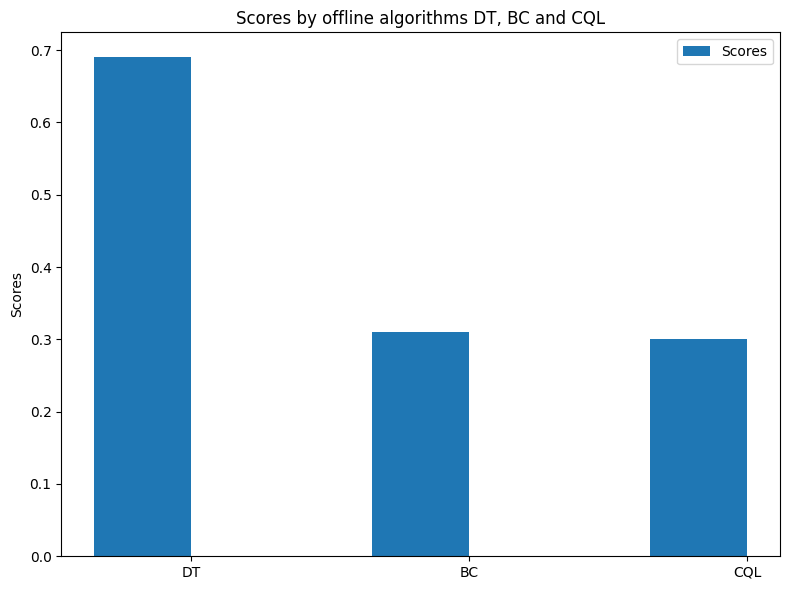

In [12]:
# We will make a bar chart to compare the performance of DQN and DT

import matplotlib.pyplot as plt

labels = ['DT', 'BC', 'CQL']
scores = [dt_score, bc_score, cql_score]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, scores, width, label='Scores')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by offline algorithms DT, BC and CQL')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

